In [22]:
# Imports

import cv2
import numpy as np
import imutils
import pytesseract
import matplotlib.pyplot as plt
import sys
import easyocr

# 1. Preprocess/enhance the image

In [23]:
def preprocess(img: np.ndarray, method: int) -> np.ndarray | None:
    """
    Applies a preprocessing operation to an image based on the specified method.

    Parameters:
        img (np.ndarray): Input image (either BGR or grayscale depending on the method).
        method (int): Preprocessing method flag:
            0 - Return original image (no preprocessing)
            1 - Convert to grayscale (cv2.COLOR_BGR2GRAY)
            2 - Apply Gaussian blur
            3 - Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            4 - Apply adaptive thresholding (binary inverse)
            5 - Detect edges using Canny algorithm
            6 - Apply morphological closing with 3x3 kernel
            7 - Convert to RGB (cv2.COLOR_BGR2RGB)
            8 - Apply bilateral filter for noise reduction while preserving edges

    Returns:
        np.ndarray | None: The preprocessed image, or None if an invalid method is passed.

    Notes:
        - Some methods expect the input image to be in grayscale (e.g., CLAHE, thresholding).
        - Make sure to preprocess in appropriate order, e.g., convert to grayscale before thresholding.
    """
    if not isinstance(img, np.ndarray):
        raise ValueError("Input 'img' must be a NumPy ndarray.")
    
    match method:
        case 0:
            return img
        case 1:
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        case 2:
            return cv2.GaussianBlur(img, (5, 5), 0)
        case 3:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            return clahe.apply(img)
        case 4:
            return cv2.adaptiveThreshold(
                img, 255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                19, 9
            )
        case 5:
            return cv2.Canny(img, 30, 200)
        case 6:
            kernel = np.ones((3, 3), np.uint8)
            return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
        case 7:
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        case 8:
            return cv2.bilateralFilter(img, 11, 17, 17)
        case _:
            return None


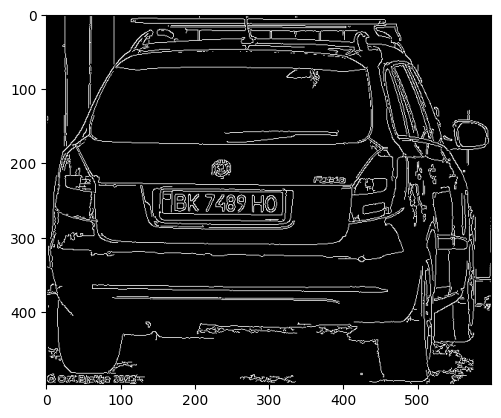

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

path_img = 'img\\ua_bk7489ho.jpg'

img = cv2.imread(path_img)

img_rgb = preprocess(img, 7)
img_gray = preprocess(img, 1)
bfilter = preprocess(img_gray, 8)
edges = preprocess(bfilter, 5)

plt.imshow(edges, cmap='grey')


# 2. Recognize the license plate - contours

In [25]:
def recognize_contours(img_edges):
    """
    Detects and returns the top 10 largest contours in a binary edge-detected image.

    Parameters:
        img_edges (numpy.ndarray): A binary image (typically the result of edge detection)
                                   where contours are to be recognized.

    Returns:
        list: A list of the top 10 contours sorted by area in descending order.
              Each contour is represented as a NumPy array of points.
    """

    keypoints = cv2.findContours(img_edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    return contours

def recognize_plate(contours):
    """
    Attempts to locate a rectangular contour that likely represents a license plate.

    Parameters:
        contours (list): A list of contours, typically obtained from cv2.findContours,
                         where each contour is a NumPy array of shape (n, 1, 2).

    Returns:
        numpy.ndarray or None: The first contour approximated to a quadrilateral (4 points),
                               assumed to be the license plate location. Returns None if no
                               such contour is found.
    """
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * peri, True)  # 0.018 * perimeter = adaptive epsilon
        if len(approx) == 4:
            return approx  # Found a quadrilateral

    return None
        

def create_mask_plate(img_gray, location):
    """
    Creates a mask for the detected license plate region and returns the cropped grayscale image.

    Parameters:
        img_gray (numpy.ndarray): The input grayscale image.
        location (numpy.ndarray): A contour (typically a quadrilateral) representing the license plate area,
                                  usually obtained from cv2.approxPolyDP.

    Returns:
        numpy.ndarray: The cropped grayscale image of the region inside the specified contour (license plate area).
    """
    if location is None:
        return None

    mask = np.zeros_like(img_gray)
    cv2.drawContours(mask, [location], -1, 255, thickness=cv2.FILLED)
    coords = np.column_stack(np.where(mask == 255))
    if coords.size == 0:
        return None  # Failsafe in case contour is invalid or outside image
    
    # Get bounding box coordinates from the white region
    y1, x1 = coords.min(axis=0)
    y2, x2 = coords.max(axis=0)
    
    cropped_image = img_gray[y1:y2 + 1, x1:x2 + 1]

    return cropped_image

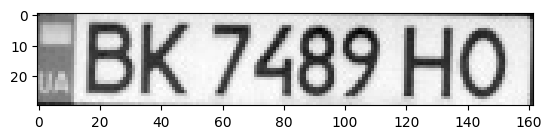

In [26]:
cont = recognize_contours(edges)
plate = recognize_plate(cont)
cropped_img = create_mask_plate(img_gray, plate)
plt.imshow(cropped_img, cmap='grey')

# 3. Apply OCR

Tesseract OCR

In [27]:
# Download and install Tesseract OCR

def ocr_license_plate(plate_img):
    """ Extract text from license plate using Tesseract OCR. """

    config = "--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    text = pytesseract.image_to_string(plate_img, config=config)

    text = "".join(filter(str.isalnum, text))  
    return text

In [30]:
cont = recognize_contours(edges)
plate = recognize_plate(cont)
cropped_img = create_mask_plate(img_gray, plate)
print(ocr_license_plate(cropped_img))

BK7489HO


EasyOCR

In [37]:
def extract_plate_text(cropped_img):
    """
    Uses OCR to read text from a cropped license plate image.

    Parameters:
        cropped_img (numpy.ndarray): The cropped grayscale or color image of the license plate.

    Returns:
        str or None: The recognized license plate text, or None if no text was detected.
    """
    if cropped_img is None:
        return None
    
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(cropped_img)

    if not result:
        return None

    return result[0][-2]


def annotate_plate(original_img, location, text):
    """
    Annotates the original image with the recognized license plate text and a bounding rectangle.

    Parameters:
        original_img (numpy.ndarray): The original image where the license plate is located.
        location (numpy.ndarray): A 4-point contour representing the license plate location.
        text (str): The text to be written on the image (e.g., license plate number).

    Returns:
        numpy.ndarray: The annotated version of the original image.
    """
    
    img_copy = original_img.copy()
    
    if not text:
        return img_copy  # No annotation if text is None or empty

    font = cv2.FONT_HERSHEY_SIMPLEX
    text_org = (location[0][0][0], location[1][0][1] + 60)

    # Draw text below the plate
    cv2.putText(img_copy, text, text_org, font, fontScale=1,
                color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    # Draw rectangle around the plate
    top_left = tuple(location[0][0])
    bottom_right = tuple(location[2][0])
    cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 3)

    return img_copy

Using CPU. Note: This module is much faster with a GPU.


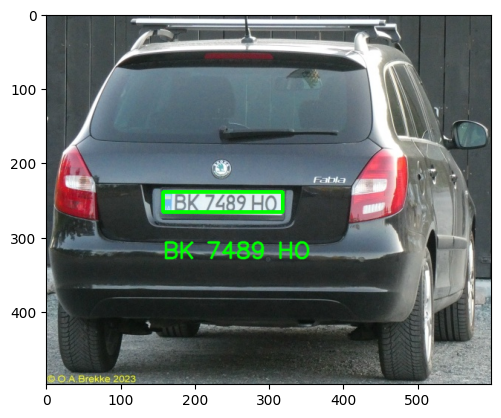

In [40]:
cont = recognize_contours(edges)
plate = recognize_plate(cont)
cropped_img = create_mask_plate(img_gray, plate)
text = extract_plate_text(cropped_img)
annot = annotate_plate(img_rgb, plate, text)
plt.imshow(annot)

# 4. Validate the number plate

Regexp to validate the number plate

# 5. Putting it all together

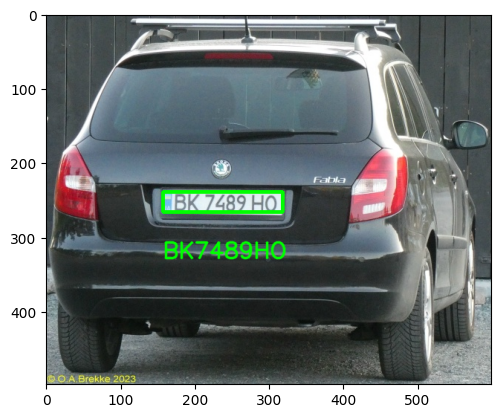

In [39]:
path_img = 'img\\ua_bk7489ho.jpg'
img = cv2.imread(path_img)

img_rgb = preprocess(img, 7)
img_gray = preprocess(img, 1)
bfilter = preprocess(img_gray, 8)
edges = preprocess(bfilter, 5)

cont = recognize_contours(edges)
plate = recognize_plate(cont)
cropped_img = create_mask_plate(img_gray, plate)

text = ocr_license_plate(cropped_img)
result = annotate_plate(img_rgb, plate, text)

plt.imshow(result)

# 6. With camera

Limited functionality, WIP

In [ ]:
s = 0
source = cv2.VideoCapture(s)

win_name = "License Plate Recognition"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

while cv2.waitKey(1) != 27:  # ESC key to quit
    has_frame, frame = source.read()
    if not has_frame:
        break

    try:
        # === Preprocessing ===
        img_rgb = preprocess(frame, 7)
        img_gray = preprocess(frame, 1)
        bfilter = preprocess(img_gray, 8)
        edges = preprocess(bfilter, 5)

        # === Plate Detection ===
        contours = recognize_contours(edges)
        plate_contour = recognize_plate(contours)

        if plate_contour is not None:
            cropped_img = create_mask_plate(img_gray, plate_contour)
            # EasyOCR is too slow for webcam
            # text extract_plate_text(cropped_img)
            text = ocr_license_plate(cropped_img)

            if text:
                frame = annotate_plate(img_rgb, plate_contour, text)

    except Exception as e:
        print("Error during processing:", e)

    cv2.imshow(win_name, frame)

source.release()
cv2.destroyWindow(win_name)
